# Reconstruction of estimated glacier states

We here present a new method to reconstruct past glacier states from climate inforamtion using the Open Glogal Glacier Model. The method consists of three main steps: generation of glacier states, identification of glacier candidates and their evaluation. The method is explained in detail in [Eis et al. (2019)](https://tc.copernicus.org/articles/13/3317/2019/tc-13-3317-2019.html). This notebook shows how to apply the developped method. A proper installation of OGGM and all dependencies are required to run this method. Knowledge on how to run OGGM is required!

### Set-up

In [1]:
import sys
import os
import salem

from initialization.core import *
from initialization.plots import *

from oggm import cfg, workflow,utils
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline
# settings for plots
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =15
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize']= 15 
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['figure.figsize'] = 10,10


cfg.initialize()

# path to working and plot directory
WORKING_DIR = 'workdir'
cfg.PATHS['working_dir'] = WORKING_DIR
print(cfg.PATHS['working_dir'])
utils.mkdir(cfg.PATHS['working_dir'], reset=False)
cfg.PATHS['plot_dir'] = os.path.join(cfg.PATHS['working_dir'], 'plots')
utils.mkdir(cfg.PATHS['plot_dir'], reset=False)

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# How many grid points around the glacier?
cfg.PARAMS['border'] = 200

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = True

# We use intersects
db = utils.get_rgi_intersects_region_file(version='61', region='11')
cfg.set_intersects_db(db)

cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['optimize_inversion_params'] = False

/home/julia/initialization/initialization/plots.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
2020-07-28 12:37:23: oggm.cfg: Using configuration file: /home/julia/oggm/oggm/params.cfg


workdir


### Glacier outlines and climate data
The glacier outlines are obtained from the Randolph Glacier Inventory. We here use a subset of the region 11 only (Oetztal Alps). As climate data we use the HISTALP dataset.  

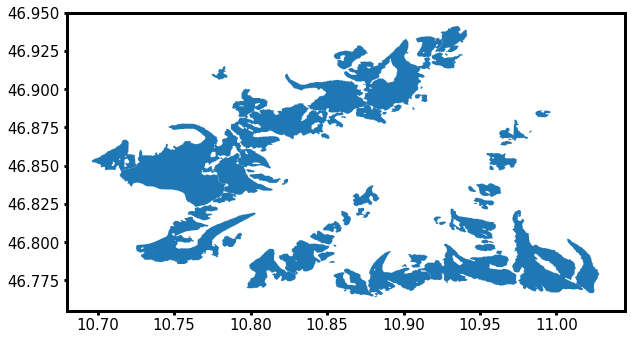

In [2]:
# read shapefile with 66 glaciers in the Oetztal Alps
rgidf = salem.read_shapefile('../rgi/oetztal.shp')

# sort for efficient using
rgidf = rgidf.sort_values('Area', ascending=False)
rgidf.plot()

# Use HISTALP climate file
cfg.PARAMS['baseline_climate'] = 'HISTALP'

### Preprocessing of OGGM
The function "preprocessing(gdirs)" runs all required steps of OGGM, before we can start to reconstruct the glacier. This includes e.g. the calculation of the flowlines, the processing of the HISTALP dataset, and the inversion.Cause to large computational costs, we will focus from now on one glacier (The Guslarferner), only.

In [14]:
# initization of OGGM
gdirs = workflow.init_glacier_regions(rgidf)
gdir = workflow.init_glacier_regions(rgidf.tail(2))[0]

# this function only needs to be run ONE time
#preprocessing(gdirs)

gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00747
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 0.011 km2
  Lon, Lat: (10.983, 46.8722)
  Grid (nx, ny): (411, 413)
  Grid (dx, dy): (11.0, -11.0)

### Synthetic experiments
We performed synthetic experiments to test the performance of our method. As the method is still under developpment, we recommend to use the method only in combination with the experiments. Otherwise it is not guaranteed, that the glacier candidates converge towards the observation and wrong reconstructions could result. A method to ensure this convergence will follow soon.  

In [15]:
# add to BASENAMES
try:
    _doc = 'contains observed and searched glacier from synthetic experiment to find intial state'
    cfg.BASENAMES['synthetic_experiment'] = ('synthetic_experiment.pkl', _doc)
except:
    pass

# creates the experiments for a list of glacier in parallel
synthetic_experiments_parallel([gdir], 1850,2000)

2020-07-28 12:40:05: oggm.core.flowline: (RGI60-11.00747) run_random_climate
2020-07-28 12:40:05: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:40:21: oggm.core.flowline: (RGI60-11.00747) default time stepping was successful!
2020-07-28 12:40:21: oggm.core.flowline: (RGI60-11.00747) run_from_climate_data_experiment
2020-07-28 12:40:21: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:40:24: oggm.core.flowline: (RGI60-11.00747) default time stepping was successful!


A glacier for the year 1850 is created by running a random climate task with the temperature bias -1 for 600 years. This glacier will be run forward from 1850 to 2000. The resulting glacier is from now on the observed glacier. 

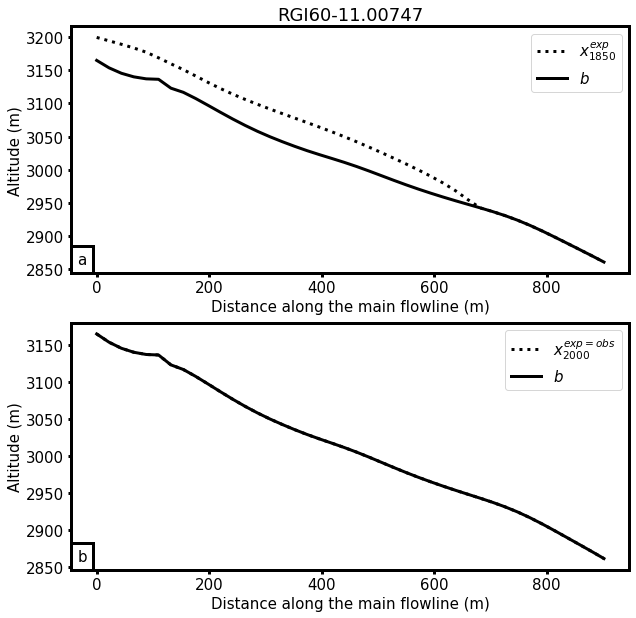

In [16]:
# reads the expermient model
ep = gdir.get_filepath('model_run', filesuffix='_experiment')
ex_mod = FileModel(ep)

# plots cross section along the flowline in 1850 and 2000
plot_experiment(gdir,ex_mod,1850,cfg.PATHS['plot_dir'])

### Reconstruction of the state in 1850
To reconstruct the glacier you need to call the function `find_possible_glaciers(gdir,y0,ye,n)`, with the GlacierDirectory `gdir`, the year of the searched state `y0`, the year of the obersvation `ye` and `n` the number of glacier candidates to test. We choose `n=200` and reconstruct this glacier in `y0=1850`. This computation can take a while (...)


In [17]:
results = find_possible_glaciers(gdir, 1850, 2000, 200)
results['volume'] = results.model.apply(lambda x: x.volume_km3)
results

2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_256_-2.2
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_16_-2.8
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_0_-3.0
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_784_-1.6
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_576_-1.8
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_144_-2.4
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_400_-2.0
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) run_random_climate1850_random_64_-2.6
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:40:39: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:40:39: oggm.core.flowlin

KeyboardInterrupt: 

2020-07-28 12:44:48: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:44:48: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:44:48: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:44:48: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:44:48: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.
2020-07-28 12:44:48: oggm.core.flowline: (RGI60-11.00747) trying default time stepping scheme.


The output is a `panda.DataFrame()` with following informations for each tested glacier candidate: OGGM's FileModel of the past climate run from y0 to ye, the objective (also called fitness) value, and the temperature bias and time point from the random climate runs to identify later which candidates was picked. From the FileModel all required inforamtions (e.g. volume, area, length, surface elevations at grid points) can be obtained. All previous model_runs will be saved and stored in a new directory named by the year. If the function should be run a second time for the same glacier (e.g. with more candidates), the algorithm first check, if this model_run was already done and reads the corresponding FileModel, if this is the case. Hereby it is avoided that the same runs will be run twice. 

### Graphics
#### Glacier candidates
The function `plot_candidates` plots the random climate tasks and the identified glacier candidates, colored by their Fitness value. 

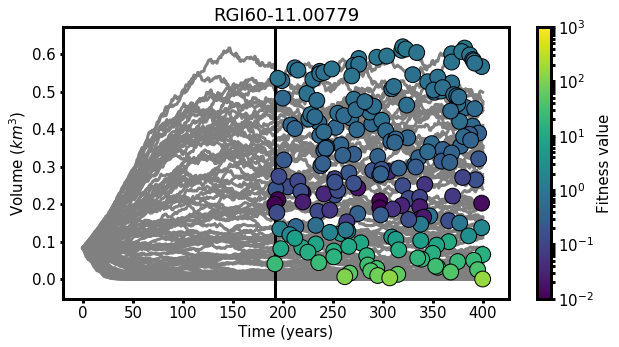

In [7]:
plot_candidates(gdir, results, 1850, cfg.PATHS['plot_dir'])

#### Cross-Section colored by Fitness value
The function `plot_surface` plot the cross-Section along the main flowline of all glacier candidates at 1850 and 2000, as well as the volumes between 1850-2000. 

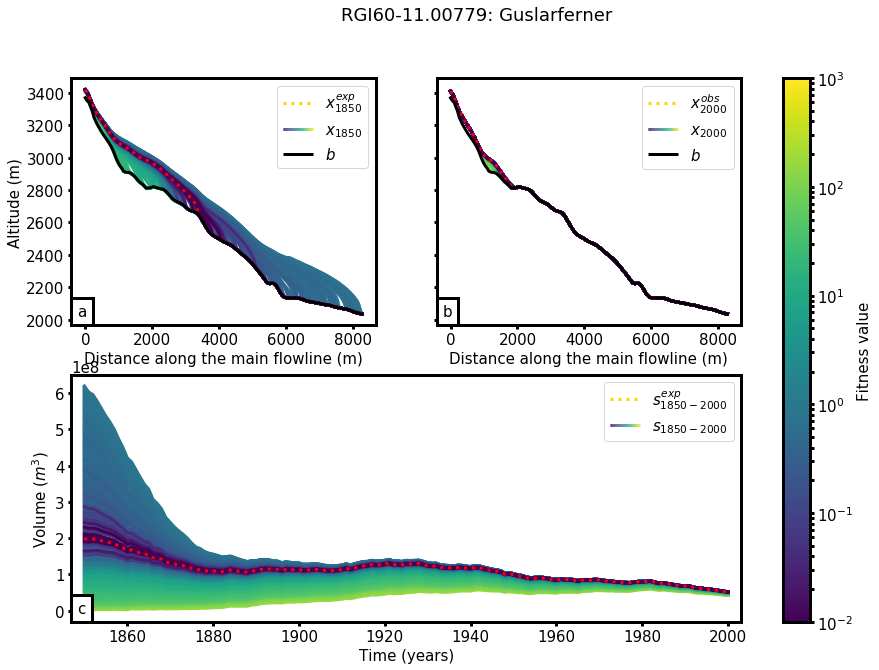

In [8]:
plot_surface(gdir,results, ex_mod,1850,cfg.PATHS['plot_dir'])

We suggest to accept all candidates with a fitness value smaller than 125 (which are in this case all, except two). A good estimate could is the median state of the 5th percentile of all acceptable states.

In [11]:
results[results['fitness']<= 125]

,fitness,model,temp_bias,time,volume,Fitness value
0,0.522449,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,199,0.529406,0.522449
1,0.752940,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,212,0.563635,0.752940
2,0.734823,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,215,0.557474,0.734823
3,0.780345,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,237,0.554321,0.780345
4,0.882324,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,276,0.588546,0.882324
5,0.948432,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,319,0.610309,0.948432
6,1.017348,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,320,0.619742,1.017348
7,0.944786,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,323,0.613831,0.944786
8,0.787130,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,334,0.604426,0.787130
9,0.881156,<oggm.core.flowline.FileModel object at 0x7f5f...,-3.00,369,0.601192,0.881156


#### Median state 
We also found out that the median state of the 5% quantile of all glaciers with a fitness value smaller than 125 fits well with the experient. To create a plot, showing the interquantile range and the median state you can use the function `plot_median`:

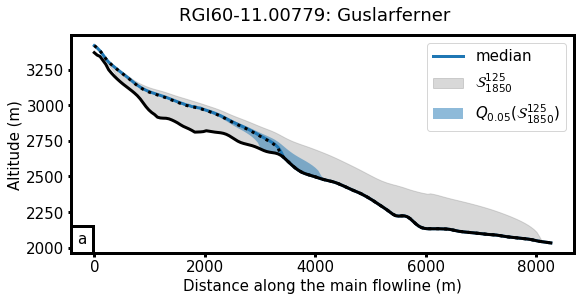

In [8]:
med_mod = plot_median(gdir,results,ex_mod,1850, cfg.PATHS['plot_dir'])

The grey area, shows all glacier states with a fitness value smaller than 125. The blue area is the 5% quantile and the blue line represents the median state. Additionally this function returns the FileModel of the median state to be able to use it for other runs. This is the best estimate of the reconstructed state in 1850. 

The uncertainties of the method are reduces, when running this state forward in time. To do so use:

In [10]:
print('error to experiment in 1850:', str(med_mod.volume_km3_ts()[1850]-ex_mod.volume_km3_ts()[1850]))

print('error to experiment in 1900', str(med_mod.volume_km3_ts()[1900]-ex_mod.volume_km3_ts()[1900]))

print('error to experiment in 1950', str(med_mod.volume_km3_ts()[1950]-ex_mod.volume_km3_ts()[1950]))

error to experiment in 1850: 0.007603731684146325
error to experiment in 1900 0.0016645326900509017
error to experiment in 1950 0.0005380207716161878
